## Script for MultiTaper Method-Singular Value Decomposition (MTM-SVD) with Monte Carlo test in python

------------------------------------------------------------------

This script is a modified version of the Python function developed by
Mathilde Jutras at McGill University, Canada[1]. 
You can find the original Python code here: 
https://github.com/mathildejutras/mtm-svd-python

This script was adapted by Yitao Liu at Nanjing University of Information Science & Technology, China
Copyright (C) 2021, Yitao Liu.
And is available under the GNU General Public License v3.0.

The script may be used, copied, or redistributed as long as it is cited as follow:

Liu-Yitao, & Mathilde Jutras. (2021). Liu-Yitao/mtm-svd-python: MTM-SVD with Monte Carlo test (v1.1.0). Zenodo. https://doi.org/10.5281/zenodo.5774584

This software may be used, copied, or redistributed as long as it is not 
sold and that this copyright notice is reproduced on each copy made. 
This routine is provided as is without any express or implied warranties.

Questions or comments to:
Yitao Liu, liuyitao97@outlook.com

Last update:
Dec 2021

------------------------------------------------------------------

The script is structured as follows:

In the main script is found in mtm-svd-python.py
In the first section, the user can load the data,
assuming the outputs are stored in a netcdf format.
In the secton section, functions are called to calculate the spectrum
The user will then be asked for which frequencies he wants to plot 
the spatial patterns associated with the variability.
In the third section, the spatial patterns are plotted and saved

The required functions are found in mtm_functions.py

------------------------------------------------------------------

Python Package needed:
- numpy
- scipy
- xarray (read the netcdf file)
- matplotlib (not necessary, just for plotting)

You can install the needed Python packages by conda,with the command below
```
conda install -c conda-forge numpy scipy xarray matplotlib
```

[1] Mathilde Jutras. (2020, July 6). mathildejutras/mtm-svd-python: v1.0.0-alpha (Version v1.0.0). Zenodo. http://doi.org/10.5281/zenodo.3932319

In [1]:
from mtm_functions import *
import xarray as xr
# from os import listdir
from os import system
import numpy as np
from scipy.signal.windows import dpss
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import time

# Load the data

/var/folders/hh/0krg6lf51vz6689tb7w8jf2c0000gn/T/ipykernel_76640/1914747435.py:16: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar=plt.colorbar()


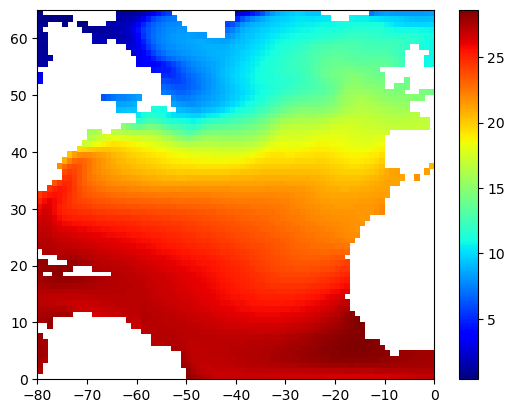

<Figure size 640x480 with 0 Axes>

In [2]:
# the data used in this sample is the SST of CMIP5 CCSM4 piControl
file_path = './ie13_PI_iTraCE.ocn.SST.degC.0001-0400.ANN.nc'
# Select the depth, in m
d = 0 
model = 'icesm13' # name of the model, for naming the output

var = xr.open_dataset(file_path)['SST'].loc[:,0:65,280-360:0]
dt = 1. # time step in years
lon = var.lon
lat = var.lat
# var = var.sel(NAME_DEPTH_VARIABLE=d, method='nearest').values

# Plot map of the variable
xgrid, ygrid = np.meshgrid(lon,lat)
plt.pcolor(xgrid, ygrid, var[0,:,:], cmap='jet')
cbar=plt.colorbar()
plt.savefig(f'Figs/{model}_data_first_timestep.jpg')
plt.show()
plt.clf()

# Compute the LVF


In [3]:
# Slepian tapers
nw = 2; # bandwidth
kk = 3; # number of orthogonal windows

# Select the frequence that need & make it a xr.DataArray
# freq >= 0.01 means period shorter than 100 years
# freq <= 0.1 means period longer than 10 years
freq_band = [0.01,0.1] # depends on the study

# Reshape the 2d array to a 1d array
o2 = var.copy().values.astype(np.float32)
o2ts = o2.reshape((o2.shape[0],o2.shape[1]*o2.shape[2]), order='F')
p, n = o2ts.shape

psi = dpss(p, nw, kk)
# Compute the LFV
freq, lfv = mtm_svd_lfv(o2ts,psi,kk,dt)

freq_sel_index = np.where((freq>=freq_band[0]) & (freq<=freq_band[1]))
freq_sel = freq[freq_sel_index]
lfv_sel = lfv[freq_sel_index]

/Users/yitao/_Dev/mtm-svd-python/mtm_functions.py:80: RuntimeWarning: Mean of empty slice
  vm = np.nanmean(ts2d, axis=0)  # Calculate the mean along the time axis
/opt/homebrew/Caskroom/mambaforge/base/envs/geopy/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


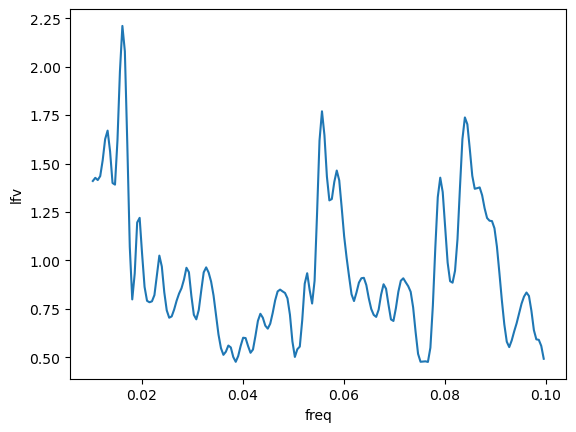

In [4]:
spectrum = xr.DataArray(lfv_sel, coords = [freq_sel], dims=['freq']).rename('lfv')
spectrum.plot()

In [5]:
freq_sel.shape

(184,)

In [6]:
niter = 1000 # should be at least 1000
sl = [0.05,0.1,0.3]
T1 = time.time()
conflevel = monte_carlo_test(o2ts,niter,sl,len(freq),psi,kk,dt)
T2 = time.time()
conflevel_sel = conflevel[:,freq_sel_index][:,0,:]

niter = 0
niter = 100
niter = 200
niter = 300
niter = 400
niter = 500
niter = 600
niter = 700
niter = 800
niter = 900


In [7]:
print('time cost of confidence: %f min' % ((T2 - T1)/60))

time cost of confidence: 20.169894 min


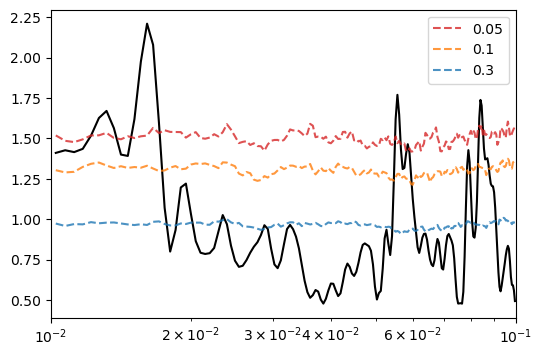

<Figure size 640x480 with 0 Axes>

In [8]:
# Display the plot to allow the user to choose the frequencies associated with peaks
fig = plt.figure(figsize=(6, 4))#,tight_layout=True
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0, 0])
ax.semilogx(freq_sel, lfv_sel, '-', c='k')
ax.semilogx(freq_sel, conflevel_sel[0,:], '--', c='tab:red', label=str(sl[0]), alpha=0.8)
ax.semilogx(freq_sel, conflevel_sel[1,:], '--', c='tab:orange', label=str(sl[1]), alpha=0.8)
ax.semilogx(freq_sel, conflevel_sel[2,:], '--', c='tab:blue', label=str(sl[2]), alpha=0.8)
ax.set_xlim([0.01,.1])
ax.legend()
plt.savefig(f'Figs/{model}_spectrum.jpg')
plt.show()
plt.clf()

In [9]:
# save data
conf_dataarray = xr.DataArray(conflevel_sel, coords=[sl, freq_sel], dims=['siglev','freq']).rename('conflev')
ds = xr.Dataset()
ds = ds.merge(spectrum.to_dataset()).merge(conf_dataarray.to_dataset())
system(f'rm -f {model}_lfv_conf.nc')
ds.to_netcdf(f'./{model}_lfv_conf.nc')


# Reconstruct spatial patterns

/Users/yitao/_Dev/mtm-svd-python/mtm_functions.py:238: RuntimeWarning: Mean of empty slice
  vm = np.nanmean(ts2d, axis=0)  # Calculate the mean along the time axis
/opt/homebrew/Caskroom/mambaforge/base/envs/geopy/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


( 33 ) 0.02 cyclesyr | 62.06 yr
( 113 ) 0.06 cyclesyr | 18.12 yr
( 174 ) 0.08 cyclesyr | 11.77 yr


/Users/yitao/_Dev/mtm-svd-python/mtm_functions.py:199: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  dum1 = np.linalg.lstsq(np.conj(qrsave1), np.linalg.lstsq(np.conj(qrsave1.T), d)[0])[0].T  # Solve the linear equation
/Users/yitao/_Dev/mtm-svd-python/mtm_functions.py:201: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  dum2 = np.linalg.lstsq(np.conj(qrsave1), np.linalg.lstsq(np.conj(qrsave1.T), za)[0])[0].T  # Solve the linear equation
/Users/yitao/_Dev/mtm-svd-python/mtm_functions.py:207: FutureWarning: `rcond` paramet

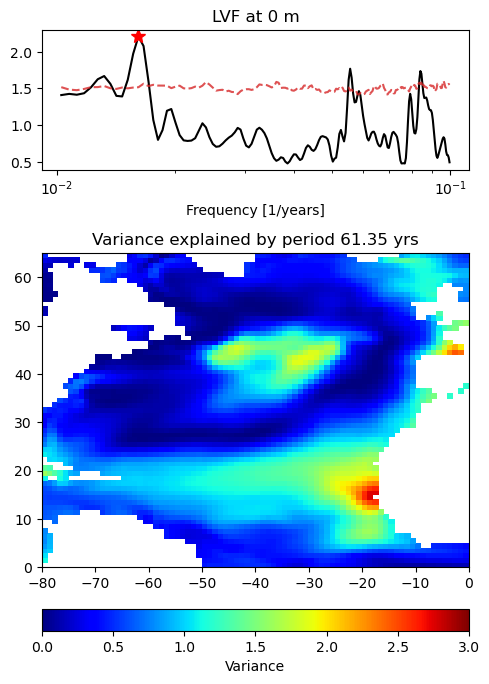

/var/folders/hh/0krg6lf51vz6689tb7w8jf2c0000gn/T/ipykernel_76640/866493002.py:21: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = fig.colorbar(pc, ax=ax2, orientation='horizontal', pad=0.1)


<Figure size 640x480 with 0 Axes>

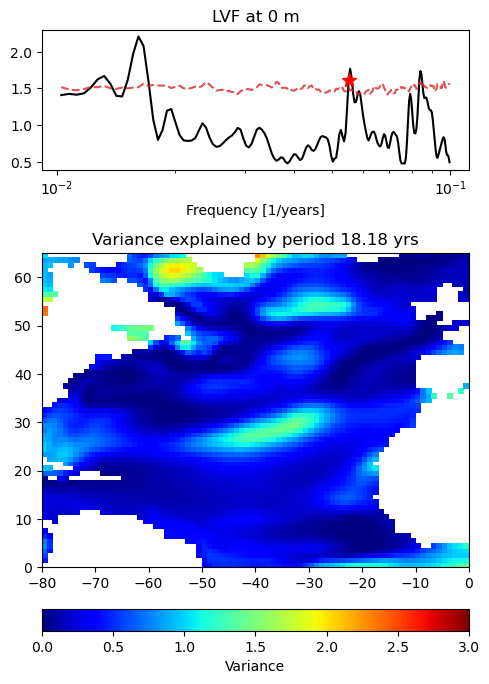

/var/folders/hh/0krg6lf51vz6689tb7w8jf2c0000gn/T/ipykernel_76640/866493002.py:21: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = fig.colorbar(pc, ax=ax2, orientation='horizontal', pad=0.1)


<Figure size 640x480 with 0 Axes>

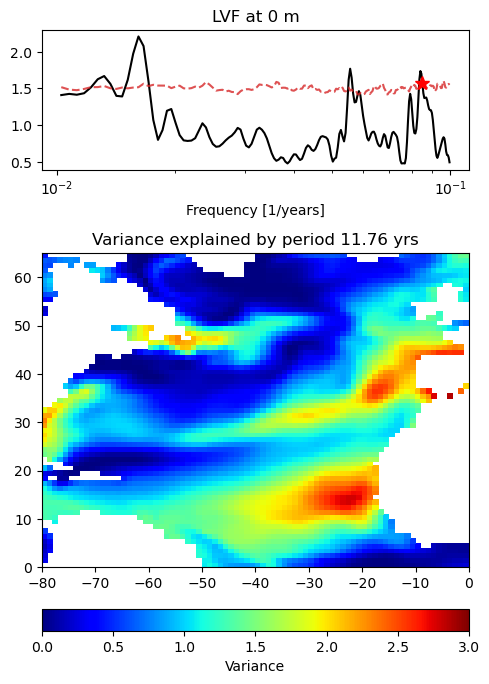

<Figure size 640x480 with 0 Axes>

In [12]:
# Select frequency(ies)
fo = [0.0163, 0.055, 0.085] 
# Calculate the reconstruction

vexp, totvarexp, iis = mtm_svd_recon(o2ts,psi,kk,dt,fo)

# Plot the map for each frequency peak

for i in range(len(fo)):
	RV = np.reshape(vexp[i],xgrid.shape, order='F')
	fig, (ax1, ax2) = plt.subplots(2,1,gridspec_kw={'height_ratios':[1,3]},figsize=(5,7))
	ax1.semilogx(freq_sel, lfv_sel, '-', c='k')
	ax1.semilogx(freq_sel, conflevel_sel[0,:], '--', c='tab:red', label=str(sl[0]), alpha=0.8)
	# ax1.semilogx(freq_sel, conflevel_sel[1,:], '--', c='tab:orange', label=str(sl[1]), alpha=0.8)
	# ax1.semilogx(freq_sel, conflevel_sel[2,:], '--', c='tab:blue', label=str(sl[2]), alpha=0.8)
	ax1.plot(freq[iis[i]],lfv[iis[i]],'r*',markersize=10)
	ax1.set_xlabel('Frequency [1/years]')
	ax1.set_title('LVF at %i m'%d)

	pc = ax2.pcolor(xgrid, ygrid, RV, cmap='jet', vmin=0, vmax=3.) 
	cbar = fig.colorbar(pc, ax=ax2, orientation='horizontal', pad=0.1)
	cbar.set_label('Variance')
	ax2.set_title('Variance explained by period %.2f yrs'%(1./fo[i]))

	plt.tight_layout()
	plt.savefig(f'Figs/{model}_peak_analysis_%s_%im_%.2fyrs.jpg'%(model,d,1./fo[i]))
	plt.show()
	plt.clf()

